<a href="https://colab.research.google.com/github/jisusP/Articulo/blob/main/Descriptores_moleculares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit-pypi
!pip install  mordred

In [2]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np

from mordred import Calculator, descriptors

In [5]:
#Smiles - Bangap (dataset)
url = 'https://raw.githubusercontent.com/gashawmg/molecular-descriptors/main/Orbital_Energies_input_data.csv'
dataset = pd.read_csv(url)
dataset.head()

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.749421
1,OC(=O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,C[C@@H](CCO)CCC=C(C)C,209.569808


## Generar los SMILES canónicos

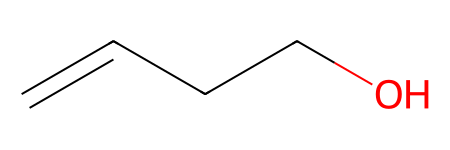

In [6]:
#Es decir, que la estructura de atrás pa' lante son las mismas, y las lea como una única molécula
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

def canon_smile(smiles):
  mols = [Chem.MolFromSmiles(smi) for smi in smiles]
  smiles = [Chem.MolToSmiles(mol) for mol in mols]
  return smiles

Chem.MolFromSmiles('C=CCCO')
#El mismo pero al revés: Chem.MolFromSmiles('OCCC=C')

In [10]:
canon_smile(['OCCC=C'])

['C=CCCO']

In [11]:
canon_smile(['C=CCCO'])

['C=CCCO']

In [19]:
#Une los iguales del dataset
canonico_smiles = canon_smile(dataset.SMILES)
#len(canonico_smiles)
dataset['SMILES'] = canonico_smiles
#dataset

#Crear una lista para los smiles duplicados
duplicados_smiles = dataset[dataset['SMILES'].duplicated()]['SMILES'].values
#len(duplicados_smiles)
dataset[dataset['SMILES'].isin(duplicados_smiles)].sort_values(by=['SMILES'])

#Borrar los valores duplicados
dataset_new = dataset.drop_duplicates(subset=['SMILES'])
dataset_new

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.749421
1,O=C(O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,CC(C)=CCC[C@@H](C)CCO,209.569808
...,...,...
2899,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.649319
2900,Brc1cccc2sccc12,162.928319
2901,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.098245
2902,c1ccc2sccc2c1,167.958431


In [17]:
##isin ¿De qué se trata ese atributo? Compara si existe un objeto en otro
# Crear un DataFrame de ejemplo
df = pd.DataFrame({'A': [1, 2, 3, 4, 5],
                   'B': ['a', 'b', 'c', 'd', 'e']})

# Verificar si los valores de la columna 'A' están presentes en un conjunto dado
valores_deseados = [2, 4, 6]
resultado = df['A'].isin(valores_deseados)

print(resultado)

0    False
1     True
2    False
3     True
4    False
Name: A, dtype: bool


In [20]:
##sort_values: sirve para ordenar el dataset
# Crear un DataFrame de ejemplo
df = pd.DataFrame({'A': [3, 1, 4, 2, 5],
                   'B': ['c', 'a', 'd', 'b', 'e']})

# Ordenar el DataFrame por la columna 'A' en orden ascendente
df_sorted = df.sort_values(by='A')

print(df_sorted)

   A  B
1  1  a
3  2  b
0  3  c
2  4  d
4  5  e


## Calcular los descriptores con rdkit

In [21]:
def rdkit_descriptores(smiles):
  mols = [Chem.MolFromSmiles(smi) for smi in smiles]
  calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
  desc_names = calc.GetDescriptorNames()

  Mol_descriptors = []
  for mol in mols:
    #agregar H a las moléculas
    mol = Chem.AddHs(mol)
    #Calcular todos los descriptores para cada molécula
    descriptors = calc.CalcDescriptors(mol)
    Mol_descriptors.append(descriptors)
  return Mol_descriptors, desc_names

Mol_descriptors, desc_names = rdkit_descriptores(dataset_new['SMILES'])

In [22]:
df_descriptores = pd.DataFrame(Mol_descriptors, columns = desc_names)
df_descriptores

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.550510,-5.076351,12.550510,1.008796,0.546828,160.138,153.082,160.049985,60,0,...,0,0,0,0,0,0,0,0,0,0
1,10.676844,-3.333333,10.676844,1.840718,0.569323,122.551,115.495,122.013457,42,0,...,0,0,0,0,0,0,0,0,0,0
2,13.050084,-4.111425,13.050084,0.722809,0.790287,361.825,341.665,361.108086,132,0,...,0,0,0,0,0,0,0,0,0,0
3,7.402685,-0.449630,7.402685,0.074321,0.582519,162.019,156.979,160.979905,48,0,...,0,0,0,0,0,0,0,0,0,0
4,8.095237,-4.484184,8.095237,1.886963,0.606746,156.269,136.109,156.151415,66,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,9.505488,-3.873136,9.505488,0.973292,0.373065,398.426,374.234,398.135324,138,0,...,0,0,0,0,0,0,0,0,0,0
2869,7.651157,-0.170718,7.651157,0.017477,0.625891,213.099,208.059,211.929533,50,0,...,0,0,0,0,0,0,0,1,0,0
2870,13.017078,-3.813937,13.017078,0.325694,0.823664,247.294,230.158,247.120843,96,0,...,0,0,0,0,0,0,0,0,0,0
2871,7.592407,-0.348333,7.592407,0.030556,0.519376,134.203,128.155,134.019021,44,0,...,0,0,0,0,0,0,0,1,0,0


## Huellas digitales (Fingerprints)

In [26]:
def morgan_fpts(data):
  Morgan = []
  for i in data:
    mol = Chem.MolFromSmiles(i)
    fpts = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
    matriz_fpts = np.array(fpts)
    Morgan.append(matriz_fpts)
  return np.array(Morgan)

Morgan_fpts = morgan_fpts(dataset_new['SMILES'])
Morgan_fingerprints = pd.DataFrame(Morgan_fpts, columns = ['col_{}'.format(i) for i in range(Morgan_fpts.shape[1])])
Morgan_fingerprints

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_2038,col_2039,col_2040,col_2041,col_2042,col_2043,col_2044,col_2045,col_2046,col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calcular descriptores usando Mordred

In [28]:
def All_Mordred_Descriptors(data):
  calc = Calculator(descriptors, ignore_3D=False)
  mols = [Chem.MolFromSmiles(smi) for smi in data]

  df = calc.pandas(mols)
  return df

mordred_descriptors = All_Mordred_Descriptors(dataset_new['SMILES'])
mordred_descriptors

100%|██████████| 2873/2873 [09:19<00:00,  5.13it/s]


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,8.302711,7.763360,0,0,12.527341,2.311476,4.622953,12.527341,1.138849,3.302522,...,9.182249,41.326257,160.049985,8.891666,152,13,54.0,59.0,5.284722,2.333333
1,4.461420,4.736714,1,0,7.727407,1.931852,3.863703,7.727407,1.103915,2.752227,...,7.321850,31.336140,122.013457,8.715247,52,4,24.0,22.0,3.861111,1.833333
2,19.038123,14.818400,1,0,30.648742,2.324224,4.648448,30.648742,1.225950,4.118873,...,9.931735,59.295845,361.108086,8.024624,1882,35,124.0,139.0,9.729167,5.486111
3,6.651690,6.355891,0,0,10.792280,2.245827,4.491654,10.792280,1.199142,3.099448,...,8.806724,37.839725,160.979905,11.498565,84,10,42.0,46.0,4.083333,2.027778
4,7.399237,7.388977,0,0,12.133645,2.047810,4.095621,12.133645,1.103059,3.219224,...,8.131825,38.565088,156.151415,5.037142,194,9,42.0,41.0,5.472222,2.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,21.758550,17.000581,0,0,38.253985,2.374938,4.749876,38.253985,1.366214,4.258939,...,10.073357,62.971588,398.135324,7.656449,2014,41,142.0,164.0,6.166667,6.361111
2869,7.806684,7.343579,0,0,13.098358,2.369838,4.633950,13.098358,1.309836,3.261311,...,9.161465,53.745115,211.929533,14.128636,105,12,52.0,61.0,2.833333,2.222222
2870,13.382658,11.741399,0,0,22.978744,2.442763,4.885526,22.978744,1.276597,3.800055,...,9.763593,50.871918,247.120843,7.060596,574,28,88.0,103.0,6.055556,4.277778
2871,7.030628,6.547610,0,0,12.170709,2.322596,4.516123,12.170709,1.352301,3.160409,...,8.914761,51.887188,134.019021,8.934601,79,9,46.0,53.0,1.972222,2.027778
